# **Análise dos Determinantes da Saúde e Nutrição de Crianças Indígenas**

**Integrantes:** Letícia Ruas, Letícia Rosa, Lívia Rodrigues e Sophia Serafim

### **Introdução:**

Este trabalho realiza uma análise dos dados do Sistema de Informação da Atenção à Saúde Indígena (SIASI), abrangendo o período de 2019 a 2022. O objetivo central é **investigar os padrões de saúde e nutrição infantil, identificando fatores de risco associados à desnutrição e ao déficit de crescimento (baixa estatura)**.

A metodologia adotada segue o seguinte pipeline:
1.  **Engenharia de Dados (ETL):** Consolidação de múltiplas bases fragmentadas (Vigilância Alimentar, Acompanhamento e Pré-natal), tratamento de inconsistências, imputação de dados faltantes e engenharia de novos atributos.
2.  **Análise Exploratória (EDA):** Investigação estatística e visual das variáveis demográficas e nutricionais para compreender o perfil da população atendida.
3.  **Análise Geoespacial:** Mapeamento dos problemas nutricionais predominantes por município, permitindo a identificação de clusters regionais de risco.
4.  **Modelagem Preditiva:** Desenvolvimento de um modelo de *Machine Learning* (Random Forest) para prever o risco de baixa estatura, utilizando técnicas avançadas de seleção de variáveis e otimização de hiperparâmetros.

### **1. Configuração do Ambiente de Desenvolvimento**

Para iniciar, configuramos nosso ambiente de trabalho instalando bibliotecas essenciais que não são nativas do Google Colab, especificamente para análise geoespacial (`geopandas`, `geobr`) e visualização interativa (`plotly`).

Em seguida, importamos as bibliotecas padrão para manipulação de dados (`pandas`, `numpy`), visualização estática (`matplotlib`, `seaborn`) e ferramentas de aprendizado de máquina (`sklearn`). Também configuramos o estilo visual dos gráficos para garantir legibilidade e montamos o Google Drive para acessar os arquivos de dados brutos.

In [1]:
# Instalação de bibliotecas geoespaciais e de visualização
!pip install geopandas geobr plotly rpy2 -q

# Importações
# Manipulação de Dados
import pandas as pd
import numpy as np

# Visualização de Dados
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
import plotly.express as px
from matplotlib.ticker import FuncFormatter

# Análise Geoespacial
import geopandas as gpd
import geobr

# Estatística e Testes de Hipóteses
from scipy import stats
from scipy.stats import chi2_contingency, t
import sys

# Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV

# Sistema e Arquivos
from google.colab import drive

# Configurações Globais
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['font.size'] = 12

# Montagem do Google Drive
drive.mount('/content/drive')

# Definição do diretório base (Ajuste conforme necessário)
folder_path = '/content/drive/MyDrive/'
print("Ambiente configurado com sucesso.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 338.0/338.0 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 30.3 MB/s eta 0:00:00
Mounted at /content/drive
Ambiente configurado com sucesso.


### **2. Coleta e Consolidação de Dados**

Os dados brutos do SIASI são disponibilizados em arquivos separados por ano e por subsistema (Vigilância Alimentar, Acompanhamento, Pré-natal).

Nesta etapa, implementamos um processo de **carga iterativa**:
1.  Percorremos a lista de anos de interesse (2019-2022).
2.  Lemos os arquivos CSV correspondentes a cada subsistema.
3.  Concatenamos os arquivos anuais em três *DataFrames* mestres (`df_vigilancia`, `df_acompanhamento`, `df_prenatal`), criando uma coluna `ano` para manter a rastreabilidade temporal. Isso nos permite trabalhar com uma visão longitudinal completa dos dados.

In [ ]:
# Estruturas para armazenar os dados temporariamente
vigilancia_dfs = {}
acompanhamento_dfs = {}
prenatal_dfs = {}
anos_analise = [2019, 2020, 2021, 2022]

print("Iniciando o carregamento das bases de dados...")

for ano in anos_analise:
    try:
        # Carregamento dos arquivos CSV (ajuste os caminhos se necessário)
        base_path = f'{folder_path}projeto_icd/data_base/'

        vigilancia_dfs[ano] = pd.read_csv(f'{base_path}vigilancia_alimentar_{ano}.csv', sep=';')
        prenatal_dfs[ano] = pd.read_csv(f'{base_path}prenatal_microdados_{ano}.csv', sep=';')
        acompanhamento_dfs[ano] = pd.read_csv(f'{base_path}acompanhamento_{ano}.csv', sep=';')
        print(f"-> Ano {ano} carregado.")
    except Exception as e:
        print(f"Erro ao carregar o ano {ano}: {e}")

# Concatenação: Unindo os anos em dataframes únicos
print("\nConcatenando bases...")
df_vigilancia = pd.concat(vigilancia_dfs).reset_index(level=0).rename(columns={'level_0': 'ano'}).reset_index(drop=True)
df_acompanhamento = pd.concat(acompanhamento_dfs).reset_index(level=0).rename(columns={'level_0': 'ano'}).reset_index(drop=True)
df_prenatal = pd.concat(prenatal_dfs).reset_index(level=0).rename(columns={'level_0': 'ano'}).reset_index(drop=True)

print("Bases consolidadas:")
print(f"- Vigilância: {df_vigilancia.shape}")
print(f"- Acompanhamento: {df_acompanhamento.shape}")
print(f"- Pré-natal: {df_prenatal.shape}")

Iniciando o carregamento das bases de dados...
-> Ano 2019 carregado.
-> Ano 2020 carregado.
-> Ano 2021 carregado.
-> Ano 2022 carregado.

Concatenando bases...
Bases consolidadas:
- Vigilância: (1160078, 30)
- Acompanhamento: (488353, 27)
- Pré-natal: (404615, 27)


### **3. Definição do Pipeline de Limpeza e Tratamento**

Dados de saúde do mundo real frequentemente contêm ruídos, inconsistências e valores ausentes. Para garantir a qualidade da análise, definimos um conjunto de funções modulares que serão aplicadas a todos os nossos *DataFrames*:

* **`limpar_dataframe`**: Realiza a padronização inicial. Converte colunas de data (que geralmente vêm como texto) para o formato `datetime`, garante que identificadores (IDs) sejam tratados como texto (strings) e não números, e padroniza textos (caixa alta, remoção de espaços).
* **`marcar_outliers`**: Identifica valores estatisticamente discrepantes em variáveis numéricas usando o método do Intervalo Interquartil (IQR), criando colunas de *flag* para esses registros.
* **`limpeza_avancada`**: Orquestra o tratamento de dados faltantes. Imputamos valores nulos categóricos com a tag "DESCONHECIDO" e valores numéricos com a mediana, uma medida robusta a outliers.
* **`limpar_e_tipar_dataframes`**: Converte colunas numéricas críticas (peso e altura) que podem ter sido lidas como texto devido ao uso de vírgula como separador decimal.

In [ ]:
def limpar_dataframe(df, nome="DataFrame"):
    """
    Realiza a limpeza básica: conversão de datas, padronização de strings e IDs.
    """
    print(f"Iniciando limpeza básica em: {nome}...")
    df_clean = df.copy()

    # 1. Conversão de colunas de data
    for col in df_clean.columns:
        if col.startswith("dt_"):
            df_clean[col] = pd.to_datetime(df_clean[col], errors="coerce")

    # 2. Garantia de IDs como string
    for col in df_clean.columns:
        if col.startswith(("co_", "cod_", "nu_")):
            df_clean[col] = df_clean[col].astype("string")

    # 3. Padronização de variáveis categóricas (texto)
    for col in df_clean.select_dtypes(include="object").columns:
        # Normalização de valores específicos
        df_clean[col] = df_clean[col].replace({
            "A qualificar para validação": np.nan,
            "FORA DE TERRA INDÍGENA SITUADA EM ÁREA RURAL": "FORA_TERRA_RURAL",
            "FORA DE TERRA INDÍGENA": "FORA_TERRA"
        })
        # Padronização para maiúsculas e remoção de espaços
        df_clean[col] = df_clean[col].str.strip().str.upper()

    return df_clean

def marcar_outliers(df, col):
    """
    Identifica outliers usando o método do Intervalo Interquartil (IQR).
    Cria uma nova coluna 'col_outlier' booleana.
    """
    if pd.api.types.is_numeric_dtype(df[col]):
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lim_inf = Q1 - 1.5 * IQR
        lim_sup = Q3 + 1.5 * IQR
        df[col + "_outlier"] = ((df[col] < lim_inf) | (df[col] > lim_sup))
    return df

def limpeza_avancada(df, nome="DataFrame"):
    """
    Executa a marcação de outliers e a imputação de valores nulos.
    """
    print(f"Executando limpeza avançada (Imputação e Outliers): {nome}")
    df_clean = df.copy()

    # Detecção de Outliers em numéricos
    col_num = df_clean.select_dtypes(include=np.number).columns.tolist()
    for col in col_num:
        df_clean = marcar_outliers(df_clean, col)

    # Imputação de Categóricos (Nulos -> 'DESCONHECIDO')
    col_categ = df_clean.select_dtypes(include="object").columns.tolist()
    for col in col_categ:
        df_clean[col] = df_clean[col].fillna("DESCONHECIDO")

    # Imputação de Numéricos (Nulos -> Mediana)
    for col in col_num:
        df_clean[col] = df_clean[col].fillna(df_clean[col].median())

    return df_clean

def limpar_e_tipar_dataframes(lista_dfs):
    """
    Corrige tipos numéricos específicos (ex: peso e altura com vírgula).
    """
    for df in lista_dfs:
        for col in df.columns:
            if col in ['nu_peso', 'nu_altura'] and pd.api.types.is_string_dtype(df[col]):
                # Substitui vírgula por ponto e converte para float
                df[col] = pd.to_numeric(df[col].str.replace(',', '.'), errors='coerce')

### **4. Execução do Pipeline de Limpeza e Integração**

Com as funções definidas, aplicamos o tratamento em cascata nas três bases de dados. Em seguida, realizamos a **integração (merge)** das bases de Vigilância Alimentar e Acompanhamento.

A chave de integração é composta pelo código do indivíduo (`co_indio_desidentificado`) e a data do atendimento (`dt_atendimento`), garantindo que estamos unindo informações do mesmo evento.

Além disso, realizamos a **Engenharia de Atributos**:
1.  Unificação de colunas duplicadas geradas pelo merge.
2.  Cálculo preciso da idade em anos (`idade_anos`) baseada na data de nascimento e atendimento.
3.  Criação da variável binária `desnutricao` para facilitar análises posteriores.

In [ ]:
# 1. Aplicação das funções de limpeza
df_vigilancia_clean = limpar_dataframe(df_vigilancia, "Vigilância")
df_acompanhamento_clean = limpar_dataframe(df_acompanhamento, "Acompanhamento")
df_prenatal_clean = limpar_dataframe(df_prenatal, "Pré-Natal")

df_vigilancia_final = limpeza_avancada(df_vigilancia_clean, "Vigilância")
df_acompanhamento_final = limpeza_avancada(df_acompanhamento_clean, "Acompanhamento")
df_prenatal_final = limpeza_avancada(df_prenatal_clean, "Pré-Natal")

# Tratamento final de nulos residuais e tipagem
dfs_lista = [df_vigilancia_final, df_acompanhamento_final, df_prenatal_final]
for df in dfs_lista:
    df.replace('SEM INFORMAÇÃO', 'DESCONHECIDO', inplace=True)
    df.fillna('DESCONHECIDO', inplace=True)
limpar_e_tipar_dataframes(dfs_lista)

# 2. Consolidação (Merge) das bases Vigilância e Acompanhamento
print("\nConsolidando DataFrames...")
chaves_merge = ['co_indio_desidentificado', 'dt_atendimento']
df_consolidado = pd.merge(
    df_vigilancia_final,
    df_acompanhamento_final,
    on=chaves_merge,
    how='outer',
    suffixes=('_vigilancia', '_acompanhamento')
)

# 3. Unificação de colunas duplicadas pós-merge
colunas_comuns = [
    'no_municipio', 'co_municipio_ibge', 'dt_nascimento', 'tp_sexo',
    'ds_cbo_familia', 'nu_peso', 'nu_altura', 'dsei_gestao'
]

for col in colunas_comuns:
    c_vig = f'{col}_vigilancia'
    c_acomp = f'{col}_acompanhamento'
    # Prioriza a informação da vigilância, preenche com acompanhamento se nulo
    if c_vig in df_consolidado.columns and c_acomp in df_consolidado.columns:
        df_consolidado[col] = df_consolidado[c_vig].combine_first(df_consolidado[c_acomp])
        df_consolidado.drop(columns=[c_vig, c_acomp], inplace=True)

# Renomeação para facilitar o acesso
df_consolidado.rename(columns={
    'ds_peso_idade_vigilancia': 'ds_peso_idade',
    'ds_estatura_idade_vigilancia': 'ds_estatura_idade',
    'tipo_aleitamento_vigilancia': 'tipo_aleitamento'
}, inplace=True)

# 4. Engenharia de Variáveis
# Preenchimento de datas de nascimento faltantes para cálculo de idade
df_consolidado['dt_nascimento'] = df_consolidado['dt_nascimento'].fillna(method='bfill')

# Cálculo da idade exata em anos
df_consolidado['idade_anos'] = (df_consolidado['dt_atendimento'] - df_consolidado['dt_nascimento']).dt.days / 365.25

# Criação do Dataset Final para Análise
df_criancas = df_consolidado.copy()
print(f"Base consolidada pronta para análise. Dimensão: {df_criancas.shape}")

Iniciando limpeza básica em: Vigilância...


/tmp/ipython-input-1581043220.py:11: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_clean[col] = pd.to_datetime(df_clean[col], errors="coerce")
/tmp/ipython-input-1581043220.py:11: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_clean[col] = pd.to_datetime(df_clean[col], errors="coerce")


Iniciando limpeza básica em: Acompanhamento...
Iniciando limpeza básica em: Pré-Natal...
Executando limpeza avançada (Imputação e Outliers): Vigilância
Executando limpeza avançada (Imputação e Outliers): Acompanhamento
Executando limpeza avançada (Imputação e Outliers): Pré-Natal

Consolidando DataFrames...


/tmp/ipython-input-2110866218.py:51: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_consolidado['dt_nascimento'] = df_consolidado['dt_nascimento'].fillna(method='bfill')


Base consolidada pronta para análise. Dimensão: (1537745, 59)


### **5. Análise Exploratória de Dados (EDA)**

Com os dados limpos, iniciamos a investigação dos padrões gerais. Respondemos aqui a perguntas fundamentais sobre a população estudada:
* **Perfil Nutricional:** Qual a prevalência de baixo peso e baixa estatura?
* **Aleitamento:** Como são as práticas de aleitamento nos primeiros dois anos de vida?
* **Demografia:** Qual a distribuição de idade e sexo das crianças atendidas?

Utilizamos gráficos de barras para visualizar as frequências categóricas, facilitando a identificação rápida dos principais grupos de risco.

/tmp/ipython-input-259517865.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_criancas, y='ds_peso_idade', ax=axes[0],
/tmp/ipython-input-259517865.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_criancas, y='ds_estatura_idade', ax=axes[1],


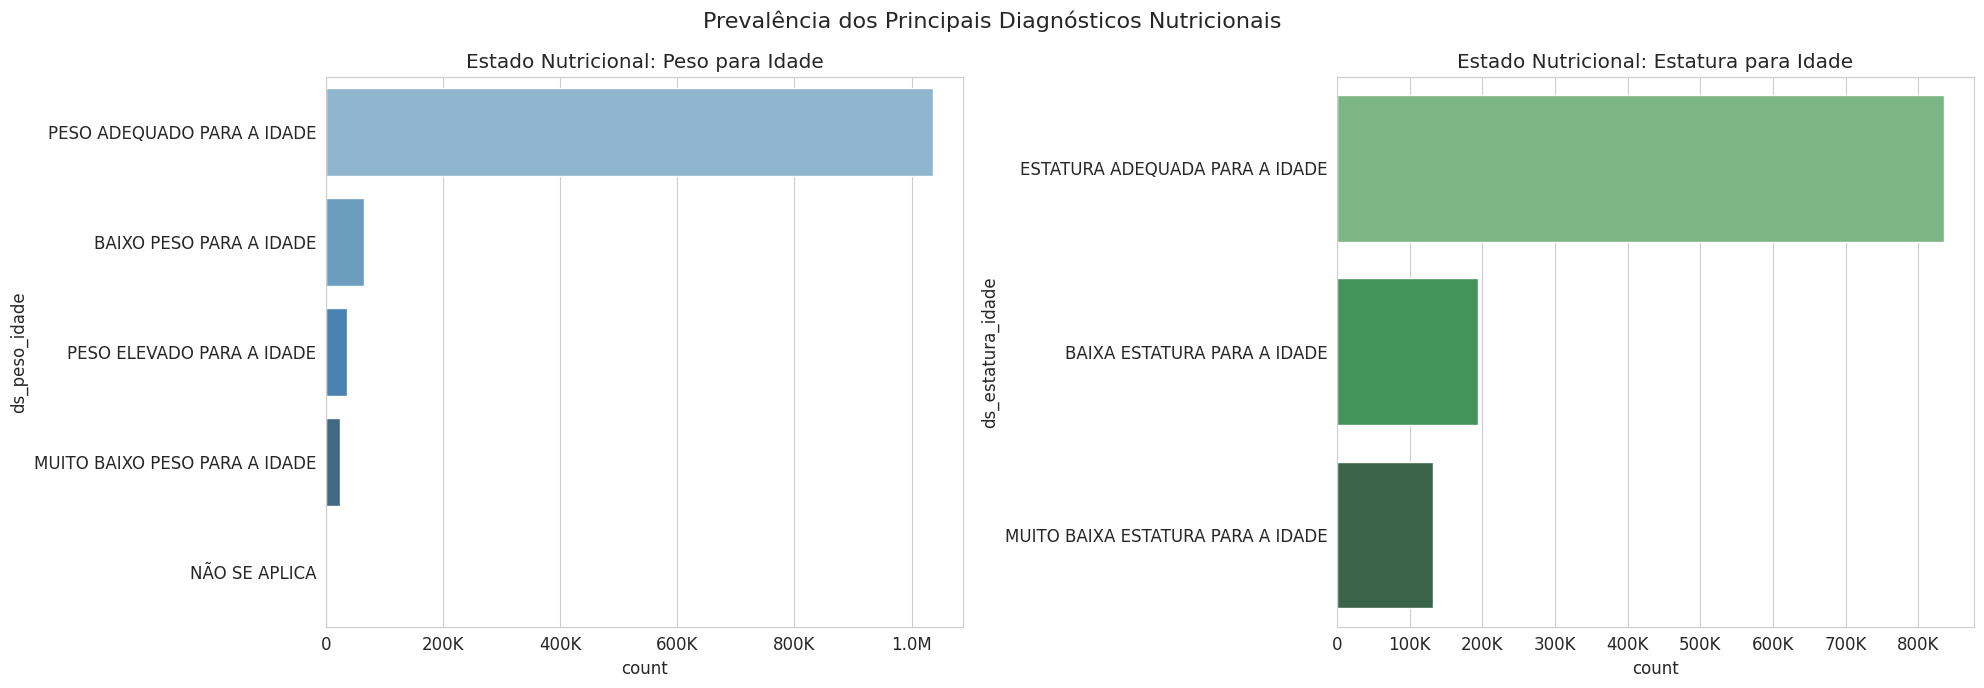

/tmp/ipython-input-259517865.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_aleitamento, y='tipo_aleitamento',


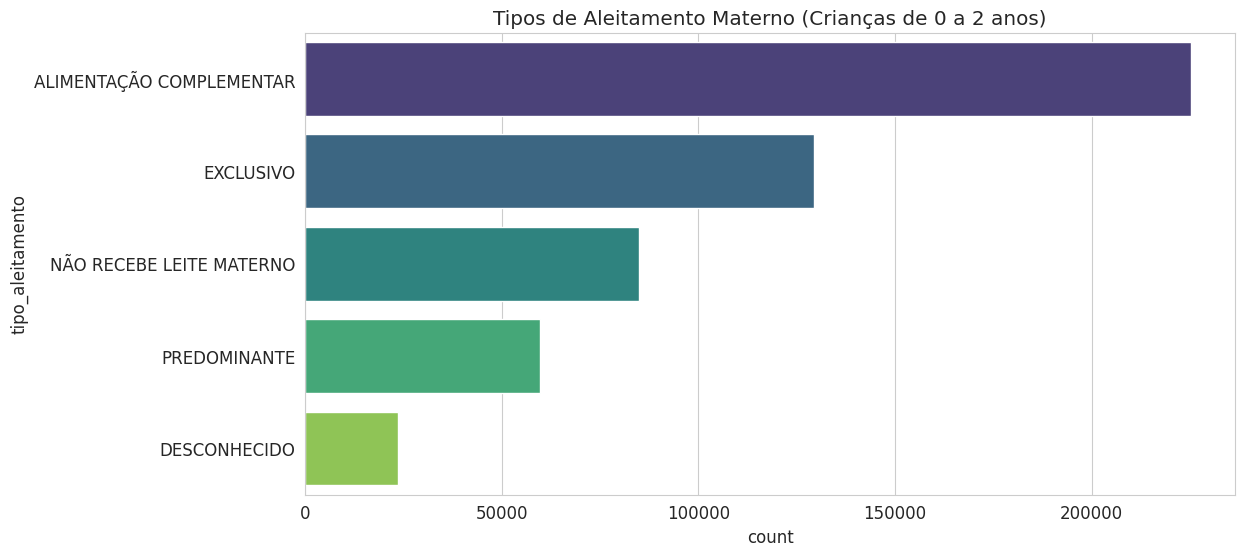

In [ ]:
# Função utilitária para formatar eixos com "M" (milhões) e "K" (milhares)
def human_readable_formatter(x, pos):
    if x >= 1_000_000: return f'{x/1_000_000:.1f}M'
    if x >= 1_000: return f'{x/1_000:.0f}K'
    return f'{x:.0f}'
formatter = FuncFormatter(human_readable_formatter)

# 1. Diagnósticos Nutricionais (Peso e Estatura)
fig, axes = plt.subplots(1, 2, figsize=(20, 7))
fig.suptitle('Prevalência dos Principais Diagnósticos Nutricionais', fontsize=16)

# Gráfico Peso x Idade
sns.countplot(data=df_criancas, y='ds_peso_idade', ax=axes[0],
              order=df_criancas['ds_peso_idade'].value_counts().index, palette='Blues_d')
axes[0].set_title('Estado Nutricional: Peso para Idade')
axes[0].xaxis.set_major_formatter(formatter)

# Gráfico Estatura x Idade
sns.countplot(data=df_criancas, y='ds_estatura_idade', ax=axes[1],
              order=df_criancas['ds_estatura_idade'].value_counts().index, palette='Greens_d')
axes[1].set_title('Estado Nutricional: Estatura para Idade')
axes[1].xaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()

# 2. Práticas de Aleitamento (Filtro: 0 a 2 anos)
df_aleitamento = df_criancas[(df_criancas['idade_anos'] >= 0) & (df_criancas['idade_anos'] < 2)]
plt.figure(figsize=(12, 6))
sns.countplot(data=df_aleitamento, y='tipo_aleitamento',
              order=df_aleitamento['tipo_aleitamento'].value_counts().index, palette='viridis')
plt.title('Tipos de Aleitamento Materno (Crianças de 0 a 2 anos)')
plt.show()

### **6. Análise Univariada de Variáveis Numéricas**

Aprofundamos a análise investigando a distribuição estatística das variáveis antropométricas principais: **Peso** e **Altura**.

Para isso, utilizamos:
* **Estatísticas Descritivas:** Média, desvio padrão, mínimos e máximos para entender a tendência central e dispersão.
* **Histogramas:** Para visualizar a forma da distribuição dos dados.
* **Boxplots:** Essenciais para identificar a presença de *outliers* (valores extremos) e visualizar a mediana.

Análise Univariada: Variáveis Numéricas

Estatísticas Descritivas:
         nu_peso  nu_altura    idade_anos
count  1160790.0  1160790.0  1.537745e+06
mean   11.525074  82.043197  1.818843e+00
std     3.802582  14.869254  1.385008e+00
min         1.48       42.0  0.000000e+00
25%          9.0       72.0  5.886379e-01
50%         11.6       84.0  1.511294e+00
75%         14.1       94.0  3.006160e+00
max         38.7      137.0  4.925394e+00


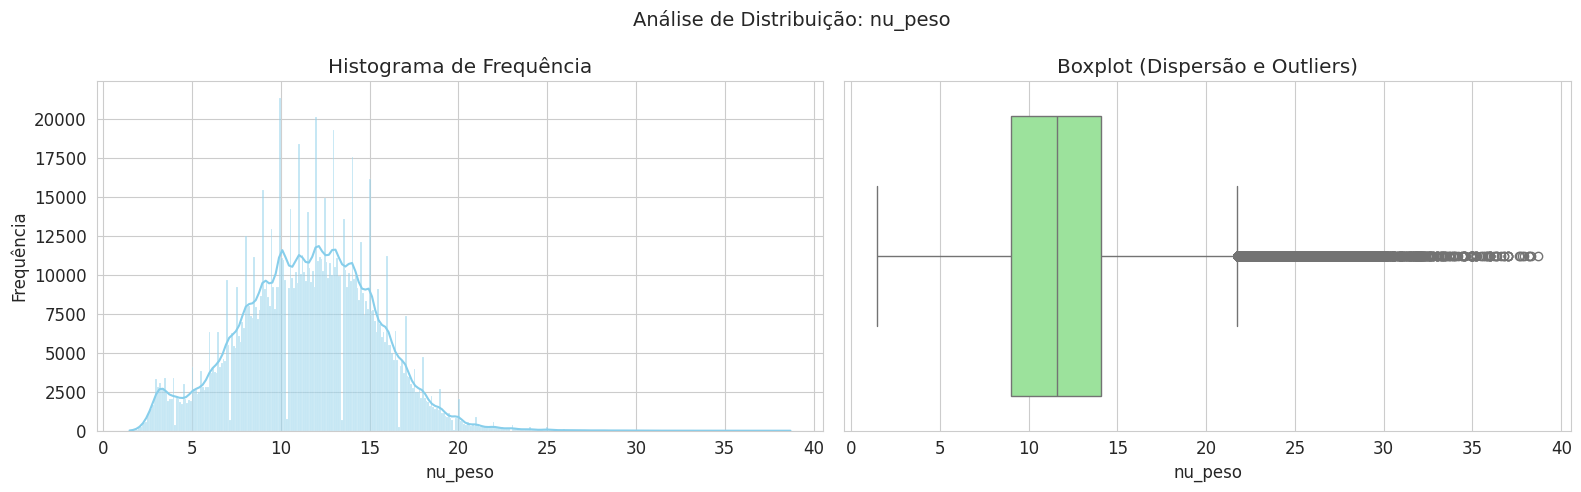

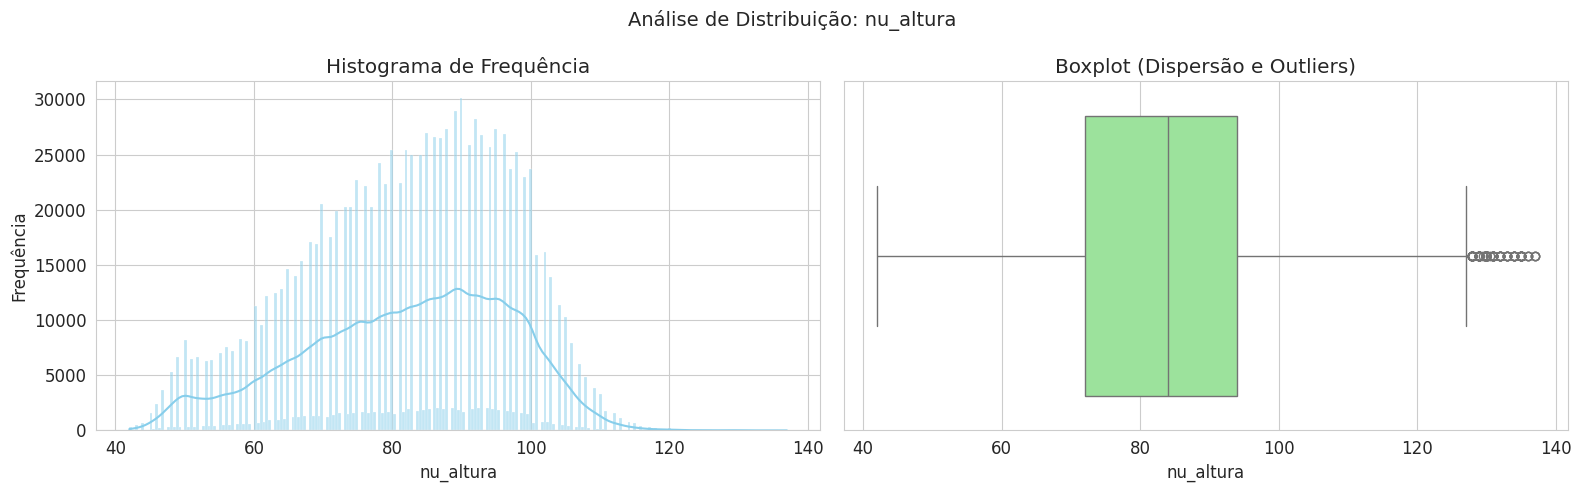

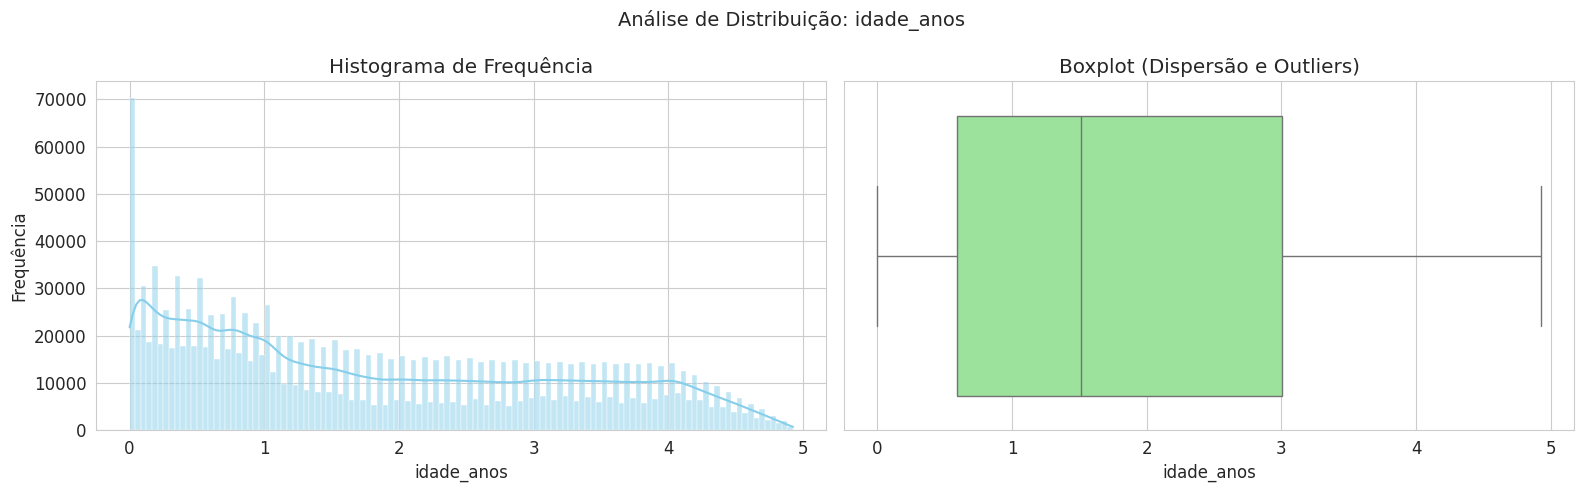

In [ ]:
print("Análise Univariada: Variáveis Numéricas")

# Seleção das variáveis de interesse presentes no dataset
numerical_vars = ['nu_peso', 'nu_altura', 'idade_anos']
vars_to_plot = [col for col in numerical_vars if col in df_criancas.columns]

# Exibição da tabela estatística
print("\nEstatísticas Descritivas:")
print(df_criancas[vars_to_plot].describe())

# Geração dos gráficos (Histograma + Boxplot) para cada variável
for var in vars_to_plot:
    # Removemos nulos apenas para a plotagem
    data_to_plot = df_criancas[var].dropna()

    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    fig.suptitle(f'Análise de Distribuição: {var}', fontsize=14)

    # Histograma (Densidade)
    sns.histplot(data_to_plot, kde=True, ax=axes[0], color='skyblue')
    axes[0].set_title('Histograma de Frequência')
    axes[0].set_ylabel('Frequência')

    # Boxplot (Outliers)
    sns.boxplot(x=data_to_plot, ax=axes[1], color='lightgreen')
    axes[1].set_title('Boxplot (Dispersão e Outliers)')

    plt.tight_layout()
    plt.show()

### **7. Análise Geoespacial: Mapeamento de Riscos**

Nesta etapa, investigamos a distribuição geográfica dos problemas de crescimento (Estatura por Idade).

A lógica aplicada é:
1.  Filtramos os dados para remover registros inválidos ou nulos.
2.  Agrupamos os dados por município para calcular a prevalência de cada diagnóstico.
3.  **Filtro:** Removemos a categoria "Estatura Adequada". Nosso objetivo é identificar qual é o **problema** predominante (Baixa ou Muito Baixa Estatura) onde ele existe.
4.  Cruzamos esses dados com a malha geográfica do IBGE (via biblioteca `geobr`) para gerar um mapa coroplético que destaca as regiões de maior vulnerabilidade.

--- 0. Preparando Dados de Estatura (Pré-requisito) ---
--- 1. Processamento das Categorias ---
Amostra das categorias de problema:
ds_estatura_idade  BAIXA ESTATURA PARA A IDADE  \
no_municipio                                     
ABARE                                       56   
ABATIA                                       1   
ABELARDO LUZ                                62   
ACARAU                                      31   
ACEGUA                                       3   

ds_estatura_idade  MUITO BAIXA ESTATURA PARA A IDADE  
no_municipio                                          
ABARE                                             25  
ABATIA                                             0  
ABELARDO LUZ                                      32  
ACARAU                                            22  
ACEGUA                                             1  


Problema mais frequente por município:
                  problema_mais_frequente
no_municipio                             
ABARE  

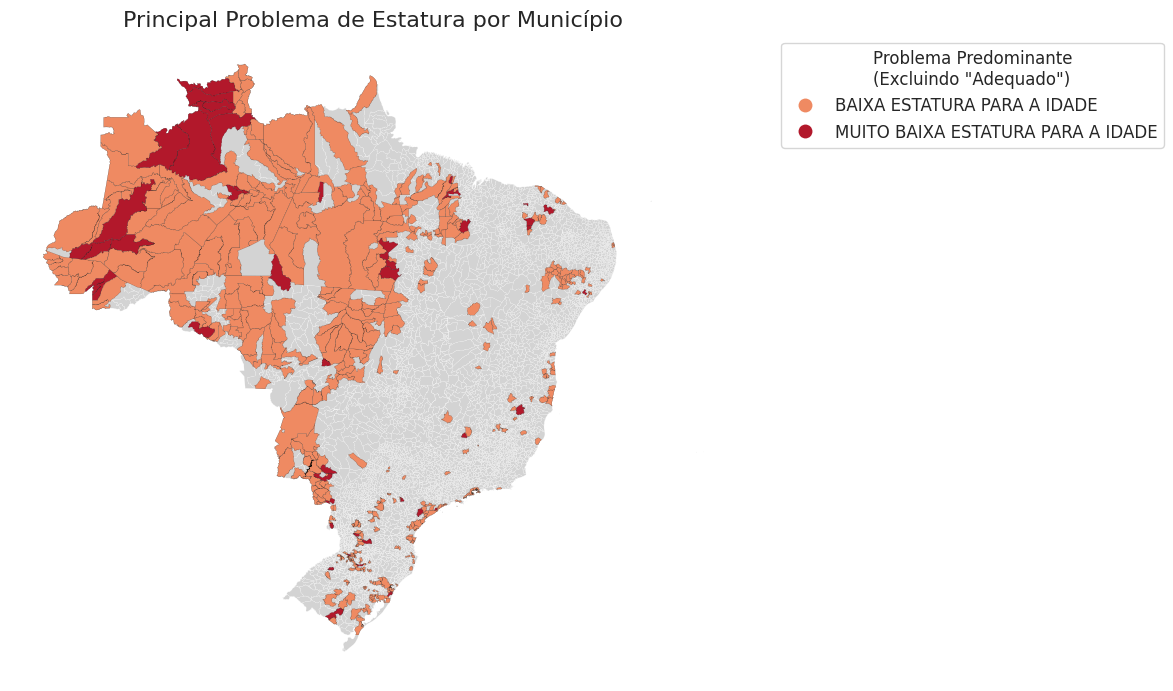

In [ ]:
# Configuração visual
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams['font.size'] = 12

print("--- 0. Preparando Dados de Estatura (Pré-requisito) ---")

# Filtra registros válidos de estatura
df_estatura_filtrado = df_criancas[
    (df_criancas['ds_estatura_idade'].notna()) &
    (df_criancas['ds_estatura_idade'] != 'NÃO SE APLICA')
].copy()

# Calcula prevalência por município
prevalencia_por_municipio = df_estatura_filtrado.groupby('no_municipio')['ds_estatura_idade'].value_counts().unstack(fill_value=0)

# Mapeamento auxiliar: Município -> Código IBGE
mapa_municipio_ibge = df_estatura_filtrado[['no_municipio', 'co_municipio_ibge']].drop_duplicates()

print("--- 1. Processamento das Categorias ---")

# Define categorias de risco (baixa estatura)
categorias_problema = [
    'MUITO BAIXA ESTATURA PARA A IDADE',
    'BAIXA ESTATURA PARA A IDADE'
]

# Filtra colunas de interesse
colunas_presentes = [col for col in prevalencia_por_municipio.columns if col in categorias_problema]
df_problemas = prevalencia_por_municipio[colunas_presentes]

print("Amostra das categorias de problema:")
print(df_problemas.head())
print("\n")

# Identifica a categoria predominante (moda)
df_frequente_problema = df_problemas.idxmax(axis=1).to_frame(name='problema_mais_frequente')

print("Problema mais frequente por município:")
print(df_frequente_problema.head())
print("\n")

# Merge com código IBGE
dados_para_mapa = df_frequente_problema.merge(
    mapa_municipio_ibge,
    left_index=True,
    right_on='no_municipio'
)

print("Dados prontos para merge:")
print(dados_para_mapa.head())
print("\n")

print("--- 2. Carregamento da Malha Geográfica ---")
try:
    # Evita recarga desnecessária da malha
    if 'gdf_municipios' not in locals():
        gdf_municipios = geobr.read_municipality(year=2020)
        print("Shapefile carregado.")
        # Ajuste IBGE: 7 para 6 dígitos
        gdf_municipios['co_ibge_6dig'] = gdf_municipios['code_muni'].astype(str).str[:6].astype(int)
    else:
        print("Shapefile já em memória.")
    print("\n")

    print("--- 3. Unificação (Merge Geoespacial) ---")

    # Padronização de tipos para o merge
    dados_para_mapa['co_municipio_ibge'] = dados_para_mapa['co_municipio_ibge'].astype(str)
    dados_para_mapa['co_municipio_ibge_numeric'] = pd.to_numeric(dados_para_mapa['co_municipio_ibge'], errors='coerce')

    # Tratamento de inconsistências
    nan_values = dados_para_mapa[dados_para_mapa['co_municipio_ibge_numeric'].isna()]
    if not nan_values.empty:
        print(f"Removendo {len(nan_values)} registros com IBGE não numérico.")
        dados_para_mapa.dropna(subset=['co_municipio_ibge_numeric'], inplace=True)

    dados_para_mapa.drop(columns=['co_municipio_ibge'], inplace=True)
    dados_para_mapa.rename(columns={'co_municipio_ibge_numeric': 'co_municipio_ibge'}, inplace=True)
    dados_para_mapa['co_municipio_ibge'] = dados_para_mapa['co_municipio_ibge'].astype(int)

    # Merge: Malha + Dados (Left Join para manter geometria do Brasil)
    mapa_final = gdf_municipios.merge(
        dados_para_mapa,
        left_on='co_ibge_6dig',
        right_on='co_municipio_ibge',
        how='left'
    )

    # Filtro para plotagem colorida
    mapa_final_dados = mapa_final.dropna(subset=['problema_mais_frequente'])

    print(f"Merge concluído. Municípios com dados: {len(mapa_final_dados)}")

    if mapa_final_dados.empty:
        print("!! Erro: Nenhum dado correspondente encontrado no merge. !!")
    else:
        print("\n--- 4. Geração do Mapa ---")

        # Definição de cores
        color_map = {
            'MUITO BAIXA ESTATURA PARA A IDADE': '#b2182b',
            'BAIXA ESTATURA PARA A IDADE': '#ef8a62'
        }

        # Ordenação para consistência na legenda
        categorias_ord = sorted(mapa_final_dados['problema_mais_frequente'].unique())
        lista_cores = [color_map[cat] for cat in categorias_ord if cat in color_map]
        cmap = matplotlib.colors.ListedColormap(lista_cores)

        # Plotagem
        fig, ax = plt.subplots(1, 1, figsize=(12, 12))

        # Camada base (Fundo)
        gdf_municipios.plot(ax=ax, color='lightgray', edgecolor='white', linewidth=0.1)

        # Camada de dados
        mapa_final_dados.plot(
            column='problema_mais_frequente',
            categorical=True,
            cmap=cmap,
            legend=True,
            legend_kwds={
                'title': 'Problema Predominante\n(Excluindo "Adequado")',
                'bbox_to_anchor': (1.05, 1),
                'loc': 'upper left'
            },
            ax=ax,
            edgecolor='black',
            linewidth=0.1
        )

        ax.set_title('Principal Problema de Estatura por Município', fontsize=16)
        ax.axis('off')

        plt.tight_layout()
        plt.show()

except Exception as e:
    print(f"Erro na geração do mapa: {e}")

### **8. Análise Bivariada e Testes Estatísticos**

Para validar estatisticamente as observações, realizamos dois testes de hipóteses fundamentais:

1.  **Teste T de Student:** Compara as médias de altura entre meninos (`M`) e meninas (`F`). O objetivo é verificar se há uma diferença estatisticamente significativa no crescimento entre os sexos nesta população.
2.  **Teste Qui-Quadrado de Independência:** Verifica se existe associação entre o **Tipo de Aleitamento** e o **Estado Nutricional (Peso)**. Isso ajuda a responder se a prática de aleitamento influencia diretamente nos diagnósticos de peso.

In [ ]:
print("Testes de Hipóteses")

# 1. Teste T: Diferença de Altura por Sexo
print("\n1. Comparação de Altura por Sexo (Teste T)")
# Preparação das amostras (removendo nulos)
amostra_m = df_criancas.loc[df_criancas['tp_sexo'] == 'M', 'nu_altura'].dropna()
amostra_f = df_criancas.loc[df_criancas['tp_sexo'] == 'F', 'nu_altura'].dropna()

# Execução do teste (assumindo variâncias diferentes - Welch's t-test)
t_stat, p_val_t = stats.ttest_ind(amostra_f, amostra_m, equal_var=False)

print(f"Média Meninos: {amostra_m.mean():.2f} cm | Média Meninas: {amostra_f.mean():.2f} cm")
print(f"Estatística T: {t_stat:.4f}")
print(f"Valor-p: {p_val_t:.6f}")
if p_val_t < 0.05:
    print("-> Resultado: Diferença estatisticamente significativa (p < 0.05).")
else:
    print("-> Resultado: Sem diferença estatisticamente significativa.")


# 2. Teste Qui-Quadrado: Aleitamento vs Estado Nutricional
print("\n2. Associação Aleitamento x Peso (Qui-Quadrado)")
# Filtro para dados válidos
df_chi = df_criancas[
    (df_criancas['tipo_aleitamento'] != 'DESCONHECIDO') &
    (df_criancas['ds_peso_idade'] != 'NÃO SE APLICA')
]

# Tabela de Contingência
tabela_contingencia = pd.crosstab(df_chi['tipo_aleitamento'], df_chi['ds_peso_idade'])

# Execução do teste
chi2, p_val_chi, dof, expected = chi2_contingency(tabela_contingencia)

print(f"Estatística Qui-Quadrado: {chi2:.4f}")
print(f"Valor-p: {p_val_chi:.6e}")
if p_val_chi < 0.05:
    print("-> Resultado: Rejeita-se a hipótese nula. Há associação significativa entre as variáveis.")
else:
    print("-> Resultado: Não se rejeita a hipótese nula. Não há evidência de associação.")

Testes de Hipóteses

1. Comparação de Altura por Sexo (Teste T)
Média Meninos: 82.55 cm | Média Meninas: 81.52 cm
Estatística T: -37.2093
Valor-p: 0.000000
-> Resultado: Diferença estatisticamente significativa (p < 0.05).

2. Associação Aleitamento x Peso (Qui-Quadrado)
Estatística Qui-Quadrado: 5338.1226
Valor-p: 0.000000e+00
-> Resultado: Rejeita-se a hipótese nula. Há associação significativa entre as variáveis.


### **9. Machine Learning: Classificação de Risco de Baixa Estatura**

Entramos na etapa preditiva do trabalho. O objetivo é criar um modelo capaz de identificar crianças em risco de déficit de crescimento com base em suas características.

**Etapas de Preparação:**
1.  **Definição do Target :** Criamos uma variável binária onde **1** representa "Baixa" ou "Muito Baixa Estatura" e **0** representa "Adequada".
2.  **Limpeza Específica para ML:** Removemos colunas que causam vazamento de dados (*data leakage*), como os diagnósticos originais, e identificadores únicos que não têm valor preditivo.
3.  **Encoding:** Transformamos variáveis categóricas (como sexo e UF) em formato numérico (One-Hot Encoding) para que o algoritmo possa processá-las.

In [ ]:
print("Preparação dos Dados para Machine Learning")

# Cópia do dataframe para não alterar o original
df_ml = df_criancas.copy()

# Tratamento rigoroso: removemos qualquer linha com 'DESCONHECIDO' ou Nulos para o modelo
df_ml = df_ml.replace('DESCONHECIDO', np.nan).dropna()

# 1. Criação do Target Binário
categorias_risco = ['BAIXA ESTATURA PARA A IDADE', 'MUITO BAIXA ESTATURA PARA A IDADE']
df_ml['target_baixa_estatura'] = np.where(df_ml['ds_estatura_idade'].isin(categorias_risco), 1, 0)

# 2. Remoção de Colunas (IDs, Datas e Variáveis Vazadas)
colunas_para_remover = [
    'ds_estatura_idade',          # Variável que originou o target (Leak)
    'ds_peso_idade',              # Altamente correlacionada (Leak parcial)
    'co_indio_desidentificado',   # ID único (sem valor preditivo)
    'dt_atendimento',             # Data
    'dt_nascimento',              # Data
    'no_municipio',               # Cardinalidade muito alta
    'no_terra_indigena',          # Cardinalidade muito alta
    'ds_cbo_familia',             # Descrição textual redundante
    'nu_altura'                   # Variável direta do cálculo do target (Leak total)
]

# Separação X (Features) e Y (Target)
Y = df_ml['target_baixa_estatura']
X = df_ml.drop(columns=colunas_para_remover + ['target_baixa_estatura'], errors='ignore')

# 3. One-Hot Encoding das variáveis categóricas
X_encoded = pd.get_dummies(X, drop_first=True)

# Reset de índices para garantir alinhamento na validação cruzada
X_cv = X_encoded.reset_index(drop=True)
Y_cv = Y.reset_index(drop=True)

print(f"Dados prontos. Features: {X_cv.shape[1]}, Amostras: {X_cv.shape[0]}")

Preparação dos Dados para Machine Learning


### **10. Seleção de Variáveis e Validação Cruzada (10-Fold)**

Com muitas variáveis geradas pelo *encoding*, precisamos identificar quais realmente importam.

1.  **Feature Importance:** Treinamos um modelo Random Forest inicial para calcular a importância de cada variável e selecionamos as **Top 20**.
2.  **Validação Cruzada (Cross-Validation):** Utilizamos a técnica de *Stratified K-Fold* (10 dobras). Isso significa que treinamos e testamos o modelo 10 vezes em fatias diferentes dos dados, garantindo que o resultado não seja fruto do acaso.
3.  **Intervalo de Confiança:** Calculamos não apenas a média da métrica F1-Score, mas também seu intervalo de confiança, oferecendo uma visão estatística robusta do desempenho do modelo.

In [ ]:
# 1. Identificação das Variáveis Mais Importantes
print("Calculando importância das variáveis...")
rf_temp = RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42)
rf_temp.fit(X_cv, Y_cv)

importancias = pd.Series(rf_temp.feature_importances_, index=X_cv.columns)
top_20_features = importancias.nlargest(20).index.tolist()
print(f"Top 5 Variáveis mais impactantes: {top_20[:5]}")

# 2. Função de Validação Cruzada com Intervalo de Confiança
def k_fold_cv_stats(X, Y, n_splits=10):
    """Executa CV e retorna média e intervalo de confiança do F1-Score Macro."""
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = []

    # Modelo base para o CV
    model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)

    print(f"Iniciando Validação Cruzada ({n_splits} folds)...")
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, Y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]

        model.fit(X_train, Y_train)
        y_pred = model.predict(X_test)

        # F1 Macro é ideal para classes desbalanceadas
        scores.append(f1_score(Y_test, y_pred, average='macro'))

    scores_arr = np.array(scores)
    mean_score = scores_arr.mean()
    # Cálculo do Intervalo de Confiança (95%)
    ci = t.interval(0.95, len(scores_arr)-1, loc=mean_score, scale=scores_arr.std(ddof=1)/np.sqrt(len(scores_arr)))

    return mean_score, ci

# Executando CV apenas com as Top 20 Features
X_20 = X_cv[top_20_features].copy()
media_f1, ci_f1 = k_fold_cv_stats(X_20, Y_cv)

print(f"\n--- Resultados do Modelo (Top 20 Features) ---")
print(f"F1-Score Macro Médio: {media_f1:.4f}")
print(f"Intervalo de Confiança (95%): {ci_f1}")

Calculando importância das variáveis...


NameError: name 'RandomForestClassifier' is not defined

### **11. Otimização de Hiperparâmetros (Grid Search)**

Para extrair o máximo desempenho do modelo, realizamos uma busca sistemática pelos melhores parâmetros de configuração (*hiperparâmetros*) do Random Forest.

Testamos combinações de:
* `n_estimators`: Número de árvores na floresta.
* `max_depth`: Profundidade máxima de cada árvore (para controlar overfitting).
* `min_samples_split`: Mínimo de amostras para dividir um nó.

O `GridSearchCV` testa todas as combinações e retorna o modelo vencedor com base na métrica F1-Macro.

In [ ]:
# Definição do espaço de busca
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

# Configuração da validação cruzada interna
skf_grid = StratifiedKFold(n_splits=3, shuffle=True, random_state=42) # 3 folds para agilizar

print("--- Iniciando Otimização de Hiperparâmetros (Grid Search) ---")
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring='f1_macro',
    cv=skf_grid,
    n_jobs=-1,
    verbose=1
)

# Treinamento com busca
grid_search.fit(X_20, Y_cv)

print("\n--- Melhores Resultados Encontrados ---")
print(f"Melhor F1-Score Macro: {grid_search.best_score_:.4f}")
print(f"Melhores Hiperparâmetros: {grid_search.best_params_}")

NameError: name 'StratifiedKFold' is not defined